### prepare modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import QUANTAXIS as QA
import talib as ta
import datetime, time
# import pandas_datareader.data as web

from utils import get_data, get_code_list_by_sector
from utils import select_code, position_side
from utils import single_pair_trading, batch_pair_trading
from utils import calc_pair_trading

try:
    from tqdm import tqdm_notebook
except:
    pass

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

### prepare data

In [3]:
code_list_by_sector = pd.read_excel('data/etf_pair_code.xlsx', dtype={'symbol':str})
sector_list = code_list_by_sector.sector.unique().tolist()
etf_list = code_list_by_sector.etf_symbol.unique().tolist()
region_list = code_list_by_sector.region.unique().tolist()

us_data = get_data('data/us_data.csv')
hk_data = get_data('data/hk_data.csv')

In [5]:
hk_data.head()

,,high,low,open,close,volume,Adj Close
date,code,,,,,,
2015-06-29,3396.hk,43.549999,42.849998,43.150002,42.950001,62651090.0,41.258984
2015-06-30,3396.hk,43.450001,43.000000,43.000000,43.349998,8230600.0,41.643234
2015-07-02,3396.hk,43.950001,42.950001,43.349998,43.849998,7664889.0,42.123547
2015-07-03,3396.hk,43.900002,42.950001,43.849998,43.000000,5044400.0,41.307014
2015-07-06,3396.hk,43.500000,40.900002,43.049999,42.549999,29058194.0,40.874729


1. 遍历得到ratio的图，还包括ratio的上下轨，rsi等等
2. 这个还是写到表里面去吧，免得麻烦
3. 但也不行，因为这个是板块的
4. 总之先把单个的先做了

In [14]:
hk_data.index.get_level_values(1).unique().tolist()

['3396.hk',
 '3969.hk',
 '0968.hk',
 '1347.hk',
 '6088.hk',
 '6869.hk',
 '1357.hk',
 '1089.hk',
 '0327.hk',
 '1980.hk',
 '0877.hk',
 '0434.hk',
 '0799.hk',
 '1337.hk']

In [4]:
result = single_pair_trading(hk_data, '3396.hk', '3969.hk')

In [5]:
result['long_return']

-0.0006266263037303483

In [6]:
result['long_short_return']

-0.0008917708617966346

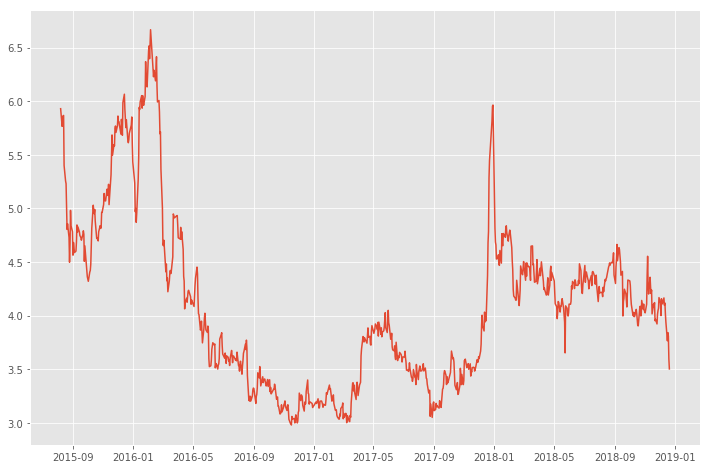

In [7]:
plt.plot(result['ratio'].index, result['ratio'].values);

1. 先选定sector
2. 再取出sector里的code
3. 

In [5]:
hk_data_code_list = hk_data.index.get_level_values(1).unique().tolist()

In [40]:
df_ratio = pd.DataFrame()
df_long_asset = pd.DataFrame()
lens = len(hk_data_code_list)
long_return_mat = np.zeros((lens,lens))
long_short_return_mat = np.zeros((lens,lens))
for i in range(lens):
    for j in range(i+1, lens):
        code1 = hk_data_code_list[i]
        code2 = hk_data_code_list[j]
        temp_result = single_pair_trading(hk_data, code1, code2)
        temp_result['ratio'].name = "%s-%s" % (code1,code2)
        temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)
        
        df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
        df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                 axis=1)
        long_return_mat[i, j] = temp_result['long_return']
        long_short_return_mat[i, j] = temp_result['long_short_return']
        
df_long_return = pd.DataFrame(long_return_mat)
df_long_return.index = hk_data_code_list
df_long_return.columns = hk_data_code_list
df_long_return

df_long_short_return = pd.DataFrame(long_short_return_mat)
df_long_short_return.index = hk_data_code_list
df_long_short_return.columns = hk_data_code_list
df_long_short_return

In [53]:
temp_result.keys()

dict_keys(['ratio', 'real_signal', 'long_asset_series', 'long_return', 'long_short_return'])

In [59]:
def batch_pair_trading(code_list, data):

    df_ratio = pd.DataFrame()
    df_long_asset = pd.DataFrame()
    lens = len(code_list)
    long_return_mat = np.zeros((lens,lens))
    long_short_return_mat = np.zeros((lens,lens))
    for i in range(lens):
        for j in range(i+1, lens):
            code1 = code_list[i]
            code2 = code_list[j]
            temp_result = single_pair_trading(data, code1, code2)
            temp_result['ratio'].name = "%s-%s" % (code1,code2)
            temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)

            df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
            df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                     axis=1)
            long_return_mat[i, j] = temp_result['long_return']
            long_short_return_mat[i, j] = temp_result['long_short_return']

    df_long_return = pd.DataFrame(long_return_mat)
    df_long_return.index = code_list
    df_long_return.columns = code_list
    df_long_return

    df_long_short_return = pd.DataFrame(long_short_return_mat)
    df_long_short_return.index = code_list
    df_long_short_return.columns = code_list
    df_long_short_return
    
    result = {}
    
    result['ratio'] = df_ratio
    result['long_asset'] = df_long_asset
    result['long_return'] = df_long_return
    result['long_short_return'] = df_long_short_return
    
    return result

In [60]:
def batch_pair_trading(code_list, data):

    df_ratio = pd.DataFrame()
    df_long_asset = pd.DataFrame()
    lens = len(code_list)
    long_return_mat = np.zeros((lens,lens))
    long_short_return_mat = np.zeros((lens,lens))
    for i in tqdm_notebook(range(lens)):
        for j in tqdm_notebook(range(i+1, lens)):
            code1 = code_list[i]
            code2 = code_list[j]
            temp_result = single_pair_trading(data, code1, code2)
            temp_result['ratio'].name = "%s-%s" % (code1,code2)
            temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)

            df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
            df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                     axis=1)
            long_return_mat[i, j] = temp_result['long_return']
            long_short_return_mat[i, j] = temp_result['long_short_return']

    df_long_return = pd.DataFrame(long_return_mat)
    df_long_return.index = code_list
    df_long_return.columns = code_list
    df_long_return

    df_long_short_return = pd.DataFrame(long_short_return_mat)
    df_long_short_return.index = code_list
    df_long_short_return.columns = code_list
    df_long_short_return
    
    result = {}
    
    result['ratio'] = df_ratio
    result['long_asset'] = df_long_asset
    result['long_return'] = df_long_return
    result['long_short_return'] = df_long_short_return
    
    return result

In [ ]:
result = batch_pair_trading(hk_data_code_list, hk_data)

In [56]:
result['long_short_return'].sum().sum()

0.075217086119152649

In [51]:
df_long_short_return.sum().sum()

0.075217086119152649

In [52]:
df_long_return.sum().sum()

0.023874766979341568

In [37]:
temp_result['long_asset_series'].name

In [ ]:
df_ratio.tail()

In [ ]:
pd.DataFrame(long_return_mat)

In [ ]:
df_ratio.applymap(lambda x: np.log(x)).plot();

### visualization

- input : sector or etf code
- output : 
    - ratio plotting
    - long return matrix
    - long short return matrix
    
- input : two code
- output :
    - ratio plotting with upper & lower bond
    - long return & long short return

sector or etf symbol list

In [ ]:
code_list_by_sector.head()

In [ ]:
code_list_by_sector.etf_symbol.value_counts().index

In [ ]:
code_list_by_sector.sector.value_counts()

In [49]:
type(code_list_by_sector.query('sector == "%s"' % 'Biotech/ Pharma').symbol.tolist()) == list

True

test

In [ ]:
us_data

In [ ]:
result = calc_pair_trading('SMH')

In [ ]:
result['ratio'].head()

In [ ]:
plt.plot(result['ratio'].index, result['ratio'].apply(lambda x : np.log(x)).values);

In [ ]:
result['ratio'].apply(lambda x : np.log(x)).plot();

In [ ]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling')

In [ ]:
plt.plot(rolling_mean_result['ratio'].index, 
         rolling_mean_result['ratio'].apply(lambda x : np.log(x)).values);

In [11]:
result['long_return'].sum().sum()

0.22396310741538117

In [ ]:
result['long_short_return'].sum().sum()

rolling mean, period : 14

In [13]:
rolling_mean_result['long_return'].sum().sum()

0.2027546976497436

In [14]:
rolling_mean_result['long_short_return'].sum().sum()

-0.06371614485490215

rolling mean, period : 20

In [ ]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling', period=20)

In [16]:
rolling_mean_result['long_return'].sum().sum()

0.21449473561696744

In [ ]:
rolling_mean_result['long_short_return'].sum().sum()

rolling mean, period : 60

In [ ]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling', period=60)

In [19]:
rolling_mean_result['long_return'].sum().sum()

0.2327909784437065

In [20]:
rolling_mean_result['long_short_return'].sum().sum()

-0.003643583266976275

find the best period

In [9]:
long_return_list = []
long_short_return_list = []
for i in tqdm_notebook(range(16,31)):
    temp_result = calc_pair_trading('SMH', method='rolling', period=int(i*10),
                                   show_bar=False)
    long_return_list.append(temp_result['long_return'].sum().sum())
    long_short_return_list.append(temp_result['long_short_return'].sum().sum())

In [7]:
long_list_1 = long_return_list.copy()

In [8]:
long_short_list_2 = long_short_return_list.copy()

In [10]:
long_list = long_list_1 + long_return_list
long_short_list = long_short_list_2 + long_short_return_list

In [16]:
long_list[16]

0.2512215653060894

In [ ]:
long_short_list[:18]

In [18]:
170/244 *12

8.360655737704917

In [3]:
ewm_mean_result = calc_pair_trading('SMH', method='ewm', period=170, show_bar=True)

In [ ]:
ewm_mean_result['long_asset']['INTC-TSM']

In [4]:
ewm_mean_result['long_short_return'].sum().sum()

0.01583926106445173

In [7]:
ewm_mean_result['long_short_return'].sum().sum()

0.015839261064451726

In [5]:
ewm_mean_result['long_return'].sum().sum()

0.2425324006094205

In [8]:
ewm_mean_result['long_return'].sum().sum()

0.24253240060942058

In [28]:
from string import ascii_letters

In [31]:
save_name = ''.join(np.random.choice(list(ascii_letters), 8))

In [32]:
save_name

'noeLrTHv'

In [33]:
is_saving = True

In [34]:
result = ewm_mean_result.copy()

In [58]:
keys = result.keys()

In [61]:
for i in result.keys():
    print(i, type(i))

ratio <class 'str'>
long_asset <class 'str'>
long_return <class 'str'>
long_short_return <class 'str'>


In [36]:
ratio = result['ratio']
long_asset = result['long_asset']
long_return = result['long_return']
long_short_return = result['long_short_return']

In [ ]:
ratio.to_excel(writer, sheet_name='ratio')

In [56]:
save_name = 'SMH_data'
if save_name is None:
    save_name = ''.join(np.random.choice(list(ascii_letters), 8))
    
result_path = os.getcwd()+'/result'
if os.path.exists(result_path) is False:
    os.makedirs(result_path)

writer = pd.ExcelWriter('result/'+save_name+'.xlsx', datetime_format='YYYY-MM-DD')

result['ratio'].to_excel(writer, sheet_name='ratio')
result['long_asset'].to_excel(writer, sheet_name='long_asset')
result['long_return'].to_excel(writer, sheet_name='long_return')
result['long_short_return'].to_excel(writer, sheet_name='long_short_return')

writer.save()

In [65]:
def store_in_excel(result, is_saving, save_name):
    
    if save_name is None:
        save_name = ''.join(np.random.choice(list(ascii_letters), 8))
    
    result_path = os.getcwd()+'/result'
    if os.path.exists(result_path) is False:
        os.makedirs(result_path)
    
    writer = pd.ExcelWriter('result/'+save_name+'.xlsx', datetime_format='YYYY-MM-DD')
    keys = list(result.keys())
    
    if (is_saving is True) or (is_saving.lower() == 'all'):
        for i in result.keys():
            result[i].to_excel(writer, sheet_name=i)
    elif is_saving.lower() == 'ratio':
        result['ratio'].to_excel(writer, sheet_name='ratio')
    elif is_saving.lower() == 'long_asset':
        result['long_asset'].to_excel(writer, sheet_name='long_asset')
    elif is_saving.lower() == 'long_return':
        result['long_return'].to_excel(writer, sheet_name='long_return')
    elif is_saving.lower() == 'long_short_return':
        result['long_return'].to_excel(writer, sheet_name='long_short_return')
    else:
        for i in is_saving:
            result[keys[i]].to_excel(writer, sheet_name=keys[i])
            
    writer.save()

In [67]:
store_in_excel(result, 'raTio', 'ratio')

In [40]:
import os
os.getcwd()

'E:\\Python\\tensorflow\\strategy_research\\task_temp'

In [51]:
result_path = os.getcwd()+'/result'
if os.path.exists(result_path) is False:
    os.makedirs(result_path)

In [46]:
os.path.exists(result_path)

True

In [55]:
'all' is 'all'

True

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
result = calc_pair_trading('SMH', method='ewm', is_saving='ratio', save_name='ratio_data',
                  period=170, show_bar=True)


finish, see youhold on...


In [ ]:
result = calc_pair_trading('SMH', method='ewm', is_saving='true', save_name='ratio_data',
                  period=170, show_bar=True)

In [8]:
from utils import *

In [14]:
store_in_excel(result, '23', 'return')

finish, see you          


In [4]:
from time import sleep

In [7]:
print('123')
print('32100000', end='')
sleep(0.5)
print('\r123')

123
12300000


In [ ]:
# from tqdm import trange
# from time import sleep
for i in trange(10, desc='1st loop', leave=False):
    for j in trange(5, desc='\r2nd loop', leave=False):
#         for k in trange(100, desc='3nd loop'):
        sleep(0.01)

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm


def myfunc(a):
    return a ** 2


N = 100
pbar = tqdm(total=N)
res = [None] * N  # result list of correct size

def wrapMyFunc(arg):
    return arg, myfunc(arg)

def update(i, ans):
    # note: input comes from async `wrapMyFunc`
    res[i] = ans  # put answer into correct index of result list
    pbar.update()

pool = Pool(2)
for i in range(N):
    pool.apply_async(wrapMyFunc, args=(i,), callback=update)
pool.close()
pool.join()
pbar.close()



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]